In [382]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [383]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping

In [384]:
input_dir = 'input'
subdirs = [d for d in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, d))]
labels = []
for subdir in subdirs:
    subdir_path = os.path.join(input_dir, subdir)
    print(subdir_path)
    files = os.listdir(subdir_path)
    for file in files:
        full_path = os.path.join(subdir_path, file)
        labels.append((full_path, subdir))


data = pd.DataFrame(labels, columns=['filename', 'label'])
data = data.sample(frac=1, random_state=42).reset_index(drop=True)


input\bishop_resized
input\knight-resize
input\pawn_resized
input\Queen-Resized
input\Rook-resize


In [385]:
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(data, test_size=0.2)

In [386]:

#Todo, fiddle with this.
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

class_count_train = train_df['label'].value_counts().to_dict()
class_count_test = test_df['label'].value_counts().to_dict()
def setup(preprocess=False):
    if preprocess:
        augmented_train = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.2)

        augmented_test = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.2)
    else:
        augmented_train = ImageDataGenerator(
            #rotation_range=10,
            #width_shift_range=0.1,
            #height_shift_range=0.1,
            #shear_range=0,
            horizontal_flip=True,
            #zoom_range=0.225,
            rescale=1/255,
            validation_split=0.2)

        augmented_test = ImageDataGenerator(
            #rotation_range=10,
            #width_shift_range=0.1,
            #height_shift_range=0.1,
            #shear_range=0,
            horizontal_flip=True,
            #zoom_range=0.225,
            rescale=1/255)
    
    train = augmented_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    target_size=(128,128),#check here
    subset="training",
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
)
    val = augmented_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    target_size=(128,128),#check here
    subset="validation",
    batch_size=32,
    class_mode='categorical',
    shuffle='False',
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    #shuffle=True
)

    test = augmented_test.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='label',
    target_size=(128,128),#check here
    batch_size=32,
    class_mode='categorical',
    seed=0,
    verbose=0,
    #chelck
)
    

    return train, val, test
train, val, test = setup()
train_1, val_1, test_1 = setup(preprocess=True)

Found 411 validated image filenames belonging to 5 classes.
Found 102 validated image filenames belonging to 5 classes.
Found 129 validated image filenames belonging to 5 classes.
Found 411 validated image filenames belonging to 5 classes.
Found 102 validated image filenames belonging to 5 classes.
Found 129 validated image filenames belonging to 5 classes.


In [387]:
#train data 
"""
train = augmented_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    target_size=(128,128),#check here
    subset="training",
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=0
)
class_count_train = train_df['label'].value_counts().to_dict()
print(class_count_train)#count of each classes value"""


'\ntrain = augmented_train.flow_from_dataframe(\n    dataframe=train_df,\n    x_col=\'filename\',\n    y_col=\'label\',\n    target_size=(128,128),#check here\n    subset="training",\n    batch_size=32,\n    class_mode=\'categorical\',\n    shuffle=True,\n    seed=0\n)\nclass_count_train = train_df[\'label\'].value_counts().to_dict()\nprint(class_count_train)#count of each classes value'

In [388]:
#train data 
"""
val = augmented_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    target_size=(128,128),#check here
    subset="validation",
    batch_size=32,
    class_mode='categorical',
    shuffle='False',
    seed=0
    #shuffle=True
)
class_count_train = train_df['label'].value_counts().to_dict()
print(class_count_train)#count of each classes value
"""

'\nval = augmented_train.flow_from_dataframe(\n    dataframe=train_df,\n    x_col=\'filename\',\n    y_col=\'label\',\n    target_size=(128,128),#check here\n    subset="validation",\n    batch_size=32,\n    class_mode=\'categorical\',\n    shuffle=\'False\',\n    seed=0\n    #shuffle=True\n)\nclass_count_train = train_df[\'label\'].value_counts().to_dict()\nprint(class_count_train)#count of each classes value\n'

In [389]:
"""
test = augmented_test.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='label',
    target_size=(128,128),#check here
    batch_size=32,
    class_mode='categorical',
    seed=0#chelck
)
class_count_test = test_df['label'].value_counts().to_dict()
print(class_count_test)
"""

"\ntest = augmented_test.flow_from_dataframe(\n    dataframe=test_df,\n    x_col='filename',\n    y_col='label',\n    target_size=(128,128),#check here\n    batch_size=32,\n    class_mode='categorical',\n    seed=0#chelck\n)\nclass_count_test = test_df['label'].value_counts().to_dict()\nprint(class_count_test)\n"

In [390]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
#from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
"""
model = models.Sequential()
#model.add(data_augmentation)
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
#model.add(layers.BatchNormalization()),
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.BatchNormalization()),
model.add(layers.MaxPooling2D((2, 2), strides=2))
#model.add(layers.Dropout(0.2))
#model.add(layers.Conv2D(8, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
"""
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(128, 128, 3)),
    #BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    #Dropout(0.2),
    
    Conv2D(64, (3, 3)),
    #BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3)),
    #BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64),
    Activation('relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])
"""
model = models.Sequential()
#data augmentation has occured previously. Relatively random.
model.add(layers.Conv2D(32, (3, 3),padding="same", kernel_regularizer=regularizers.l2(0.03), activation='relu', input_shape=(128, 128, 3)))#consider grtting rid of color
model.add(layers.BatchNormalization()),
model.add(layers.MaxPooling2D((2, 2), strides=2))

#convolutuon 2
model.add(layers.Conv2D(64, (3, 3),padding="same", kernel_regularizer=regularizers.l2(0.03), activation='relu', input_shape=(128, 128, 3)))#consider grtting rid of color
model.add(layers.BatchNormalization()),
model.add(layers.MaxPooling2D((2, 2), strides=2))

#convolutuon 3
model.add(layers.Conv2D(128, (3, 3),padding="same", kernel_regularizer=regularizers.l2(0.03), activation='relu', input_shape=(128, 128, 3)))#consider grtting rid of color
model.add(layers.BatchNormalization()),
model.add(layers.MaxPooling2D((2, 2), strides=2))

model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.03), activation='relu')),
model.add(layers.BatchNormalization()),
model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.03), activation='relu')),
model.add(layers.BatchNormalization()),
model.add(layers.Dense(5, activation='softmax'))
"""



'\nmodel = models.Sequential()\n#data augmentation has occured previously. Relatively random.\nmodel.add(layers.Conv2D(32, (3, 3),padding="same", kernel_regularizer=regularizers.l2(0.03), activation=\'relu\', input_shape=(128, 128, 3)))#consider grtting rid of color\nmodel.add(layers.BatchNormalization()),\nmodel.add(layers.MaxPooling2D((2, 2), strides=2))\n\n#convolutuon 2\nmodel.add(layers.Conv2D(64, (3, 3),padding="same", kernel_regularizer=regularizers.l2(0.03), activation=\'relu\', input_shape=(128, 128, 3)))#consider grtting rid of color\nmodel.add(layers.BatchNormalization()),\nmodel.add(layers.MaxPooling2D((2, 2), strides=2))\n\n#convolutuon 3\nmodel.add(layers.Conv2D(128, (3, 3),padding="same", kernel_regularizer=regularizers.l2(0.03), activation=\'relu\', input_shape=(128, 128, 3)))#consider grtting rid of color\nmodel.add(layers.BatchNormalization()),\nmodel.add(layers.MaxPooling2D((2, 2), strides=2))\n\nmodel.add(layers.Dropout(0.3))\nmodel.add(layers.Flatten())\nmodel.add(

In [391]:
from sklearn.utils.class_weight import compute_class_weight

classes = list(class_count_train.keys())
print(class_count_train)
y = np.concatenate([[i] * class_count_train[cls] for i, cls in enumerate(classes)])
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
weight_dict = {i: weight for i, weight in enumerate(weights)}
print(weight_dict)

{'knight-resize': 133, 'bishop_resized': 112, 'Rook-resize': 110, 'Queen-Resized': 98, 'pawn_resized': 60}
{0: 0.7714285714285715, 1: 0.9160714285714285, 2: 0.9327272727272727, 3: 1.046938775510204, 4: 1.71}


In [392]:
from keras.callbacks import EarlyStopping 

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
#callback commented out
callback = [EarlyStopping(monitor='val_loss', patience = 50, restore_best_weights=True)]#tweak patience
history = model.fit(train, class_weight=weight_dict, epochs=15, 
validation_data=val, callbacks=callback)

#here we see the accuracy and validation accuracy over time. Please note we have a halting mechanism in place


Epoch 1/15
13/13 [==============================] - 5s 337ms/step - loss: 1.6743 - accuracy: 0.2725 - val_loss: 1.5913 - val_accuracy: 0.2255
Epoch 2/15
13/13 [==============================] - 5s 365ms/step - loss: 1.5945 - accuracy: 0.2944 - val_loss: 1.5778 - val_accuracy: 0.2451
Epoch 3/15
13/13 [==============================] - 5s 367ms/step - loss: 1.5762 - accuracy: 0.3187 - val_loss: 1.5606 - val_accuracy: 0.3039
Epoch 4/15
13/13 [==============================] - 6s 449ms/step - loss: 1.4996 - accuracy: 0.3650 - val_loss: 1.5200 - val_accuracy: 0.3235
Epoch 5/15
13/13 [==============================] - 6s 443ms/step - loss: 1.4091 - accuracy: 0.3966 - val_loss: 1.4607 - val_accuracy: 0.4314
Epoch 6/15
13/13 [==============================] - 7s 516ms/step - loss: 1.2737 - accuracy: 0.4842 - val_loss: 1.5184 - val_accuracy: 0.3824
Epoch 7/15
13/13 [==============================] - 7s 500ms/step - loss: 1.2308 - accuracy: 0.4988 - val_loss: 1.4682 - val_accuracy: 0.4216
Epoch 

In [393]:
    

#history = model.fit(train, epochs=25, 
                  #  validation_data=(val), steps_per_epoch=train.samples//32,validation_steps=val.samples//32)

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

"\nplt.plot(history.history['accuracy'], label='accuracy')\nplt.plot(history.history['val_accuracy'], label = 'val_accuracy')\nplt.xlabel('Epoch')\nplt.ylabel('Accuracy')\nplt.ylim([0, 1])\nplt.legend(loc='lower right')\n"

In [394]:
#Here we see how we truly do for labeling each of the images, Note, augmented images are augmented.
from sklearn.metrics import classification_report

def report(model, name):
    #test.reset()
    if name == "Liam":
        true_labels = test.classes
        print(true_labels)
        predictions = model.predict(test)
    else:
        true_labels = test_1.classes
        print(true_labels)
        predictions = model.predict(test_1)
    pred_classes = np.argmax(predictions, axis=1)
    d = {0: 'bishop_resized', 1: "knight-resize", 2: "pawn_resized", 3: "Queen-Resized", 4: "Rook-resize"}
    pred_classes = [d[i] for i in pred_classes]
    true_labels = [d[i] for i in true_labels]
    print(pred_classes)
    report = classification_report(true_labels, 
                                   pred_classes, 
                                   zero_division=1)
    #print(true_labels)
    return report


In [395]:
#pretrained model 
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
"""
inputs = tf.keras.Input(shape = (128,128,3))
preprocess = tf.keras.applications.mobilenet.preprocess_input(inputs)
upscale = tf.keras.layers.Lambda(lambda x : tf.image.resize_with_pad(x,
                                                                     128,
                                                                     128,
                                                                     method = tf.image.ResizeMethod.BILINEAR))(inputs)
mobilenet_model = tf.keras.applications.MobileNetV2(input_shape=(128,128,3),
                                                   include_top=False,
                                                   weights="imagenet", input_tensor = (upscale))
mobilenet_model.trainable=False
mobile = Sequential()
mobile.add(mobilenet_model)
mobile.add(layers.Flatten())
mobile.add(layers.Dense(5,activation="softmax"))
mobile.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

hist = mobile.fit(train,
                    epochs=10,
                    batch_size=32,
                    callbacks=callback,
                    verbose=1,
                    validation_data=val, class_weight=weight_dict)

"""
mobile_model = tf.keras.applications.MobileNetV2(input_shape=(128,128, 3),
                include_top=False,
                weights='imagenet',
                pooling='avg')
mobile_model.trainable = False
inputs = mobile_model.input
x = Dense(64, activation='relu')(mobile_model.output)
x = Dense(64, activation='relu')(x)
outputs = Dense(5, activation='softmax')(x)
mobile = Model(inputs=inputs, outputs=outputs)
mobile.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
history = mobile.fit(train_1, validation_data=val_1, epochs=25,callbacks=callback,verbose=1);
                    


Epoch 1/25
13/13 [==============================] - 7s 354ms/step - loss: 1.3989 - accuracy: 0.4428 - val_loss: 1.1807 - val_accuracy: 0.6275
Epoch 2/25
13/13 [==============================] - 4s 291ms/step - loss: 0.7723 - accuracy: 0.7664 - val_loss: 0.8515 - val_accuracy: 0.6961
Epoch 3/25
13/13 [==============================] - 4s 307ms/step - loss: 0.4202 - accuracy: 0.8929 - val_loss: 0.8103 - val_accuracy: 0.6765
Epoch 4/25
13/13 [==============================] - 4s 333ms/step - loss: 0.2637 - accuracy: 0.9270 - val_loss: 0.6673 - val_accuracy: 0.7941
Epoch 5/25
13/13 [==============================] - 4s 340ms/step - loss: 0.1363 - accuracy: 0.9757 - val_loss: 0.6585 - val_accuracy: 0.7745
Epoch 6/25
13/13 [==============================] - 5s 359ms/step - loss: 0.0758 - accuracy: 0.9951 - val_loss: 0.6479 - val_accuracy: 0.7843
Epoch 7/25
13/13 [==============================] - 4s 332ms/step - loss: 0.0447 - accuracy: 0.9976 - val_loss: 0.6301 - val_accuracy: 0.7941
Epoch 

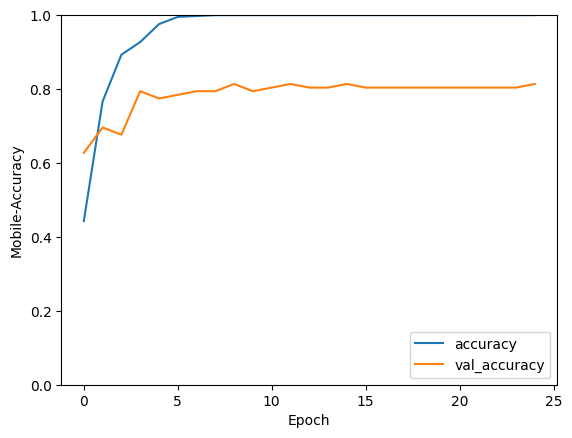

In [396]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Mobile-Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [398]:

print("_______________Liams Model__________________")
print(report(model, "Liam"))
print("_______________Mobile Net___________________")
print(report(mobile, "Mobile"))

_______________Liams Model__________________
[3, 4, 3, 4, 1, 2, 4, 0, 3, 1, 1, 0, 3, 0, 2, 2, 4, 2, 2, 4, 3, 2, 3, 3, 3, 3, 2, 3, 1, 3, 1, 3, 2, 0, 3, 0, 1, 3, 2, 1, 4, 4, 0, 3, 2, 4, 1, 1, 3, 1, 1, 2, 3, 0, 4, 2, 3, 1, 3, 2, 2, 2, 3, 2, 1, 3, 1, 1, 2, 3, 2, 3, 4, 0, 4, 1, 4, 4, 3, 4, 3, 2, 3, 0, 3, 0, 1, 4, 1, 3, 1, 3, 3, 3, 1, 2, 2, 1, 3, 2, 2, 2, 1, 1, 0, 4, 0, 3, 1, 3, 0, 0, 3, 1, 2, 2, 3, 2, 1, 4, 0, 4, 0, 3, 2, 1, 1, 4, 2]
5/5 [==============================] - 0s 74ms/step
['knight-resize', 'Queen-Resized', 'Queen-Resized', 'pawn_resized', 'Queen-Resized', 'bishop_resized', 'bishop_resized', 'Queen-Resized', 'pawn_resized', 'Queen-Resized', 'pawn_resized', 'knight-resize', 'knight-resize', 'knight-resize', 'Queen-Resized', 'bishop_resized', 'Queen-Resized', 'pawn_resized', 'knight-resize', 'pawn_resized', 'Queen-Resized', 'Queen-Resized', 'Queen-Resized', 'pawn_resized', 'Queen-Resized', 'Queen-Resized', 'Queen-Resized', 'pawn_resized', 'Queen-Resized', 'bishop_resized', 'pawn_r